# I. Introduction

In this exercise, you'll implement several local search algorithms and test them on the [Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem) (TSP) between a few dozen US state capitals.  Briefly, the TSP is an optimization problem that seeks to find the shortest path passing through every city exactly once.  In our example the TSP path is defined to start and end in the same city (so the path is a closed loop).

Local search algorithms are important in artificial intelligence because many tasks can be represented as [optimization problems](https://en.wikipedia.org/wiki/Optimization_problem).  For example, [here](https://blog.openai.com/evolution-strategies/) researches used evolutionary strategies to perform gradient-free training of deep neural networks (which allows non-differentiable activation and loss functions), and [here](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/BeamSearchDecoder) is an example of using beam search for tasks like optimal sentence translation in natural language processing.

The TSP problem itself is interesting and has been studied extensively because it can be applied to a variety of useful real-world problems. It has been used in logistics & operations research for vehicle routing and order-picking in warehouses, product development and design like computer wiring & printed circuit board masking, and various scheduling problems, among others.

![Simulated Annealing](SA_animation.gif)
Image Source: [Simulated Annealing - By Kingpin13 (Own work) [CC0], via Wikimedia Commons (Attribution not required)](https://commons.wikimedia.org/wiki/File:Hill_Climbing_with_Simulated_Annealing.gif)

## Overview

Search for `#TODO` tags to quickly find the functions you are required to implement. Descriptions and pseudocode for each function are provided in the notebook, along with links to external readings.

  0. Complete the `TravelingSalesmanProblem` class by implementing the `successors()`, `get_successor()`, and `__get_value()` methods
  0. Complete the `HillClimbingSolver` class
  0. Complete the `LocalBeamSolver` class
  0. Complete the `SimulatedAnnealingSolver` class
  0. Complete the `LAHCSolver` class

In [1]:
import sys
import json
import math # contains sqrt, exp, pow, etc.
import random
import time
import numpy as np
import re
from itertools import chain, product, combinations, permutations, repeat

from collections import deque
from helpers import *

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## I. Representing the Problem

The first step is to build a representation of the problem domain.  The choice of representation can have a significant impact on the performance of the various optimization algorithms.  Since the TSP deals with a closed loop that visits each city in a list once, we will represent each city by a tuple containing the city name and its position specified by an (x,y) location on a grid: (<NAME>, (x, y)).  The _state_ will then consist of an ordered sequence of the cities in the path. In other words, the path is defined as the sequence generated by traveling from each city in the list to the next in order.

For example, the path (("City1", (x1, y1)), ("City2", (x2, y2)), ("City3", (x3, y3))) defines a circuit from City1 -> City2 -> City3 -> City1. 

In [2]:

def dist(xy1, xy2):
    """ Calculate the distance between two points.
    
    You may choose to use Euclidean distance, Manhattan distance, or some
    other metric
    """
    # DONE: Implement this function!
    return math.sqrt( (xy1[0]-xy2[0])**2 + (xy1[1]-xy2[1])**2 )



class TravelingSalesmanProblem:
    """ Representation of a traveling salesman optimization problem.
    
    An instance of this class represents a complete circuit of the cities
    in the `path` attribute.
    
    
    Parameters
    ----------
    cities : iterable
        An iterable sequence of cities; each element of the sequence must be
        a tuple (name, (x, y)) containing the name and coordinates of a city
        on a rectangular grid. e.g., ("Atlanta", (585.6, 376.8))
        
    shuffle : bool
        If True, then the order of the input cities (and therefore the starting
        city) is randomized.
    
    Attributes
    ----------
    names : sequence
        An iterable sequence (list by default) containing only the names from
        the cities in the order they appear in the current TSP path

    coords : sequence
        An iterable sequence (list by default) containing only the coordinates
        from the cities in the order they appear in the current TSP path

    path : tuple
        A path between cities as specified by the order of the city
        tuples in the list.
    """
    def __init__(self, cities, shuffle=False, swap_size=2):
        ##### YOU DO NOT NEED TO MODIFY THIS FUNCTION #####
        if shuffle:
            cities = list(cities)
            random.shuffle(cities)
        self.path = tuple(cities)   # using a tuple makes the path sequence immutable
        self.__utility = None       # access this attribute through the .utility property
        self.swap_size = min(swap_size, len(cities)-2)  # how many nearest neighbours to detangle
        self.cache = {}
            
        
    def copy(self, shuffle=False):
        ##### YOU DO NOT NEED TO MODIFY THIS FUNCTION #####
        cities = list(self.path)
        if shuffle: random.shuffle(cities)
        return TravelingSalesmanProblem(cities)
    
    @property
    def names(self):
        """Strip and return only the city name from each element of the
        path list. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> ["Atlanta", ...]
        """
        ##### YOU DO NOT NEED TO MODIFY THIS FUNCTION #####
        names, _ = zip(*self.path)
        return names
    
    @property
    def coords(self):
        """ Strip the city name from each element of the path list and
        return a list of tuples containing only pairs of xy coordinates
        for the cities. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> [(585.6, 376.8), ...]
        """
        ##### YOU DO NOT NEED TO MODIFY THIS FUNCTION #####
        _, coords = zip(*self.path)
        return coords
    
    @property
    def utility(self):
        """ Calculate and cache the total distance of the path in the
        current state.
        """
        ##### YOU DO NOT NEED TO MODIFY THIS FUNCTION #####
        if self.__utility is None:
            self.__utility = self.__get_value()
        return self.__utility
    
    def successors(self):
        """ Return a list of states in the neighborhood of the current state.
        
        You may define the neighborhood in many different ways; although some
        will perform better than others. One method that usually performs well
        for TSP is to generate neighbors of the current path by selecting a
        starting point and an ending point in the current path and reversing
        the order of the nodes between those boundaries.
        
        For example, if the current list of cities (i.e., the path) is [A, B, C, D]
        then the neighbors will include [B, A, C, D], [C, B, A, D], and [A, C, B, D].
        (The order of successors does not matter.) 
        
        Returns
        -------
        iterable<Problem>
            A list of TravelingSalesmanProblem instances initialized with their list
            of cities set to one of the neighboring permutations of cities in the
            present state
        """
        # TODO: Implement this function!
        
        if not self.cache.get('successors', {}):             
            ### Swap neighbours    
            neighborhood = (
                self.path[:n] + tuple(reversed(self.path[n:n+size])) + self.path[n+size:]
                for size in range(2,self.swap_size+1)                
                for n    in range(len(self.path)-(size-1))
            )

            ### All Permutations         
            # neighborhood = (
            #     path 
            #     for path in permutations(self.path, len(self.path))
            #     if path != self.path
            # )        
            self.cache['successors'] = tuple([ self.__class__(neighbor) for neighbor in neighborhood ])
        return self.cache['successors']

    
    def get_successor(self):
        """ Return a random state from the neighborhood of the current state.
        
        You may define the neighborhood in many different ways; although some
        will perform better than others. One method that usually performs well
        for TSP is to generate neighbors of the current path by selecting a
        starting point and an ending point in the current path and reversing
        the order of the nodes between those boundaries.
        
        For example, if the current list of cities (i.e., the path) is [A, B, C, D]
        then the neighbors will include [B, A, C, D], [C, B, A, D], and [A, C, B, D].
        (The order of successors does not matter.) 

        Returns
        -------
        list<Problem>
            A list of TravelingSalesmanProblem instances initialized with their list
            of cities set to one of the neighboring permutations of cities in the
            present state
        """
        # DONE: Implement this function!
        return random.choice( self.successors() )

    
    def __get_value(self):
        """ Calculate the total length of the closed-circuit path of the current
        state by summing the distance between every pair of cities in the path
        sequence. 
        
        For example, if the current path is (A, B, C, D) then the total path length is:
            
            dist = DIST(A, B) + DIST(B, C) + DIST(C, D) + DIST(D, A)
        
        You may use any distance metric that obeys the triangle inequality (e.g.,
        Manhattan distance or Euclidean distance) for the DIST() function.
        
        Since the goal of our optimizers is to maximize the value of the objective
        function, multiply the total distance by -1 so that short path lengths
        are larger numbers than long path lengths. 
        
        Returns
        -------
        float
            A floating point value with the total cost of the path given by visiting
            the cities in the order according to the self.cities list
        
        Notes
        -----
            (1) Remember to include the edge from the last city back to the first city
            
            (2) Remember to multiply the path length by -1 so that short paths have
                higher value relative to long paths
        """
        # DONE: Implement this function!
        return -1 * sum(
                [ dist(self.path[i][1],self.path[i+1][1]) for i in range(len(self.path)-1) ] 
              + [ dist(self.path[-1][1],self.path[0][1]) ]
        )
    

In [3]:
# Construct an instance of the TravelingSalesmanProblem and test `.__get_value()`
test_cities = [('DC', (11, 1)), ('SF', (0, 0)), ('PHX', (2, -3)), ('LA', (0, -4))]
tsp = TravelingSalesmanProblem(test_cities, swap_size=2)
assert round(-tsp.utility, 2) == 28.97, \
    "There was a problem with the utility value returned by your TSP class."
print("Looks good!")

Looks good!


In [4]:
# Test the successors() method
successor_paths = set([x.path for x in tsp.successors()])
expected_paths = [
    (('SF', (0,  0)), ('DC',  (11, 1)), ('PHX', (2, -3)), ('LA',  (0, -4))), 
    (('DC', (11, 1)), ('LA',  (0, -4)), ('SF',  (0, 0)),  ('PHX', (2, -3))), 
    (('LA', (0, -4)), ('PHX', (2, -3)), ('DC',  (11, 1)), ('SF',  (0,  0)))
]
print('tsp.path',tsp.path)
print('successor_paths', len(successor_paths))
print('tsp.get_successor()', tsp.get_successor())
for path in successor_paths: print(path)

assert all(contains(successor_paths, x) for x in expected_paths), \
    "It looks like your successors list does not implement the suggested neighborhood function."
print("Looks good!")

tsp.path (('DC', (11, 1)), ('SF', (0, 0)), ('PHX', (2, -3)), ('LA', (0, -4)))
successor_paths 3
tsp.get_successor() <__main__.TravelingSalesmanProblem object at 0x113477160>
(('SF', (0, 0)), ('DC', (11, 1)), ('PHX', (2, -3)), ('LA', (0, -4)))
(('DC', (11, 1)), ('PHX', (2, -3)), ('SF', (0, 0)), ('LA', (0, -4)))
(('DC', (11, 1)), ('SF', (0, 0)), ('LA', (0, -4)), ('PHX', (2, -3)))
Looks good!


### Create an instance of the TSP for testing
Run the next cell to create an instance of the TSP that will be used to test each of the local search functions by finding a shortest-path circuit through several of the US state capitals.

You can increase the `num_cities` parameter (up to 30) to experiment with increasingly larger domains, and set `shuffle=True` to randomize the starting city.  Try running the solvers repeatedly -- how stable are the results?

Initial path value: 7783.88
(('Sacramento', (68.4, 254.0)), ('Des Moines', (447.6, 246.0)), ('Columbia', (632.4, 364.8)), ('Albany', (702.0, 193.6)), ('Atlanta', (585.6, 376.8)), ('Indianapolis', (548.0, 272.8)), ('Austin', (389.2, 448.4)), ('Montgomery', (559.6, 404.8)), ('Richmond', (673.2, 293.6)), ('Boise', (159.6, 182.8)), ('Raleigh', (662.0, 328.8)), ('Hartford', (719.6, 205.2)), ('Harrisburg', (670.8, 244.0)), ('Tallahassee', (594.8, 434.8)), ('Phoenix', (179.6, 371.2)), ('Little Rock', (469.2, 367.2)), ('Saint Paul', (451.6, 186.0)), ('Nashville', (546.4, 336.8)), ('Boston', (738.4, 190.8)), ('Baton Rouge', (489.6, 442.0)), ('Madison', (500.8, 217.6)), ('Lansing', (563.6, 216.4)), ('Providence', (735.2, 201.2)), ('Jackson', (501.6, 409.6)), ('Denver', (293.6, 274.0)), ('Salt Lake City', (204.0, 243.2)), ('Oklahoma City', (392.8, 356.4)), ('Salem', (80.0, 139.2)), ('Columbus', (590.8, 263.2)), ('Trenton', (698.8, 239.6)))


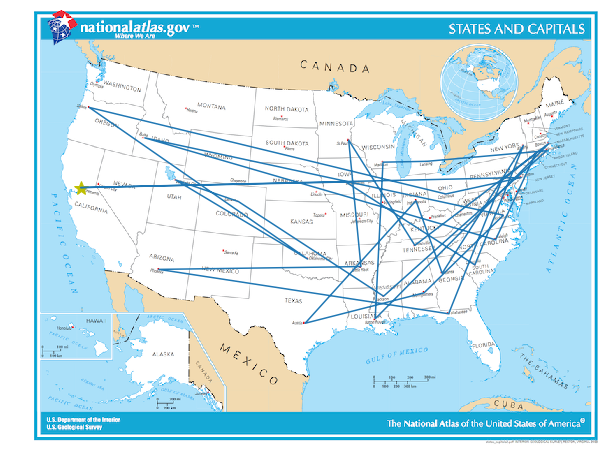

In [5]:
# Create the problem instance and plot the initial state
max_cities = len(capitals_list) # == 30
num_cities = 30
shuffle = False
cities  = capitals_list[:num_cities]

capitals_tsp  = TravelingSalesmanProblem(capitals_list[:num_cities], shuffle=shuffle)
starting_city = capitals_tsp.path[0]
print("Initial path value: {:.2f}".format(-capitals_tsp.utility))
print(capitals_tsp.path)  # The start/end point is indicated with a yellow star
show_path(capitals_tsp.coords, starting_city)

## II. Hill Climbing
Next, complete the `solve()` method for the `HillClimbingSolver` class below.

> The hill-climbing search algorithm is the most basic local search technique. At each step the current node is replaced by the neighbor with the highest value. [AIMA 3rd ed, Chapter 4]

![](pseudocode/hill_climbing.png)
Pseudocode for the [hill climbing function](https://github.com/aimacode/aima-pseudocode/blob/master/md/Hill-Climbing.md) from the AIMA textbook.  Note that our Problem class is already a "node", so the MAKE-NODE line is not required.

In [6]:
class HillClimbingSolver:
    """ 
    Parameters
    ----------
    epochs : int
        The upper limit on the number of rounds to perform hill climbing; the
        algorithm terminates and returns the best observed result when this
        iteration limit is exceeded.
    """
    
    def __init__(self, epochs=100):
        self.epochs = epochs
        self.epochs_used = 0
    
    def solve(self, problem: TravelingSalesmanProblem) -> TravelingSalesmanProblem:
        """ Optimize the input problem by applying greedy hill climbing.

        Parameters
        ----------
        problem : Problem
            An initialized instance of an optimization problem. The Problem class
            interface must implement a callable method "successors()" which returns
            a iterable sequence (i.e., a list or generator) of the states in the
            neighborhood of the current state, and a property "utility" which returns
            a fitness score for the state. (See the `TravelingSalesmanProblem` class
            for more details.)

        Returns
        -------
        Problem
            The resulting approximate solution state of the optimization problem
            
        
        Notes
        -----
            (1) DO NOT include the MAKE-NODE line from the AIMA pseudocode
        """
        # DONE: Implement this function!
        current = problem
        self.epochs_used = 0
        for i in range(self.epochs):
            self.epochs_used += 1
            successors        = sorted(current.successors(), key=lambda s: s.utility, reverse=True)
            if successors[0].utility > current.utility:
                current = successors[0]
            else:
                break
        return current
                        

### Run the Hill Climbing Solver

Observations:
- increasing swap_size exponentially increase neighbourhood permutations, but often reduces number of epochs
- swap_size=20 is usually only 2-3x slower runtime than swap_size=2
- increasing swap_size usually results in same or better path_lengths
- sometimes increasing swap_size will have a worse path length due to getting trapped in a local minima
- best swap_size varies between 2 and 20
- hill climbing with random restarts returns a linear decrease in path length with exponential increase in time

swap:   2 | epochs: 100 | path: 7784 -> 6561 | time:     60ms | epochs:    10
swap:   3 | epochs: 100 | path: 7784 -> 6199 | time:     28ms | epochs:    12
swap:   4 | epochs: 100 | path: 7784 -> 6038 | time:     29ms | epochs:    12
swap:   5 | epochs: 100 | path: 7784 -> 6038 | time:     27ms | epochs:    12
swap:   6 | epochs: 100 | path: 7784 -> 6038 | time:     28ms | epochs:    12
swap:   7 | epochs: 100 | path: 7784 -> 6038 | time:     30ms | epochs:    12
swap:   8 | epochs: 100 | path: 7784 -> 6038 | time:     33ms | epochs:    12
swap:   9 | epochs: 100 | path: 7784 -> 6042 | time:     26ms | epochs:     8
swap:  10 | epochs: 100 | path: 7784 -> 6042 | time:     27ms | epochs:     8
swap:  11 | epochs: 100 | path: 7784 -> 6042 | time:     39ms | epochs:     8
swap:  12 | epochs: 100 | path: 7784 -> 6042 | time:     35ms | epochs:     8
swap:  13 | epochs: 100 | path: 7784 -> 6042 | time:     35ms | epochs:     8
swap:  14 | epochs: 100 | path: 7784 -> 6042 | time:     31ms | 

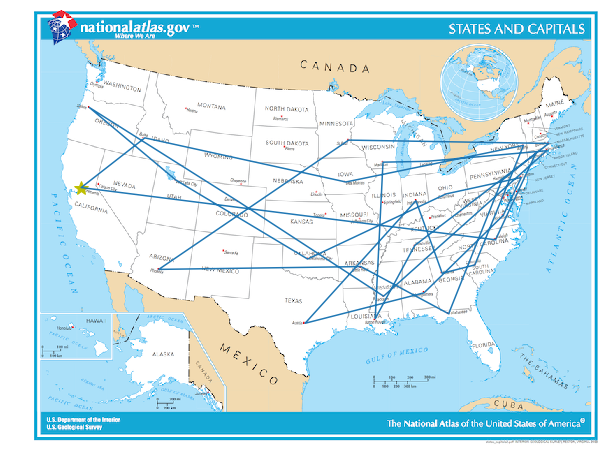

In [7]:
def HillClimbingRunner(cities, epochs=20, swap_size=29):
    capitals_tsp  = TravelingSalesmanProblem(cities, shuffle=False, swap_size=swap_size)
    starting_city = capitals_tsp.path[0]        

    solver     = HillClimbingSolver(epochs=epochs)
    start_time = time.perf_counter()
    result     = solver.solve(capitals_tsp)
    stop_time  = time.perf_counter()
    print("swap: {:3d} | epochs: {:3d} | path: {:.0f} -> {:.0f} | time: {:6.0f}ms | epochs: {:5d}"
        .format(capitals_tsp.swap_size, epochs, -capitals_tsp.utility, -result.utility, ((stop_time - start_time) * 1000), solver.epochs_used)
    )
    return result
    
# cities = random.sample(capitals_list, len(capitals_list))[:num_cities]
for swap_size in range(2,len(cities)):
    result = HillClimbingRunner(cities, swap_size=swap_size, epochs=100)

print()    
print(result.path)
show_path(result.coords, starting_city)

Run 100 times with a range of swap_sizes and get the best result

costs | min: 3821 | avg:    4321 | max: 4959 | std: 227
swaps | min:    2 | median:   18 | max:   29 | std:   7


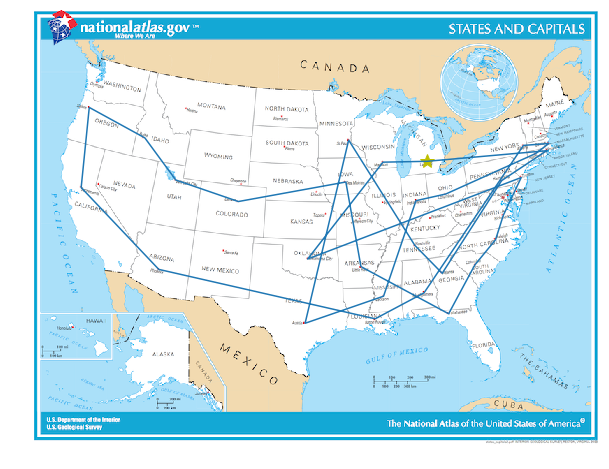

In [8]:
best_costs     = []
best_swaps     = []
best_path      = ()
best_path_cost = np.inf
for n in range(0,100):
    best_cost = np.inf
    best_swap = 0
    
    for swap_size in range(2,len(cities)):
        capitals_tsp  = TravelingSalesmanProblem(
            capitals_list[:num_cities], 
            shuffle=True, 
            swap_size=swap_size
        )
        starting_city = capitals_tsp.path[0]        
        solver        = HillClimbingSolver(epochs=100)
        start_time    = time.perf_counter()
        result        = solver.solve(capitals_tsp)
        stop_time     = time.perf_counter()
        if -result.utility < best_cost: 
            best_cost = -result.utility
            best_swap = swap_size
            if best_cost < best_path_cost:
                best_path_cost = best_cost
                best_path      = (result.coords, starting_city)
    best_costs.append(best_cost)
    best_swaps.append(best_swap)    

print("costs | min: {:4.0f} | avg:    {:4.0f} | max: {:4.0f} | std: {:3.0f}".format(min(best_costs), np.mean(best_costs), max(best_costs), np.std(best_costs)))
print("swaps | min: {:4.0f} | median: {:4.0f} | max: {:4.0f} | std: {:3.0f}".format(min(best_swaps), np.median(best_swaps), max(best_swaps), np.std(best_swaps)))
show_path(*best_path)

Run with a fixed swap size and variable iterations with random restarts

HillClimbingSolver |     1 tries | min: 5321 | avg: 5321 | max: 5321 | std:   0 | time:  0.077s
HillClimbingSolver |     5 tries | min: 4868 | avg: 5554 | max: 6127 | std: 436 | time:  0.303s
HillClimbingSolver |    10 tries | min: 4868 | avg: 5511 | max: 6127 | std: 370 | time:  0.544s
HillClimbingSolver |    50 tries | min: 3984 | avg: 5409 | max: 6590 | std: 552 | time:  2.433s
HillClimbingSolver |   100 tries | min: 3984 | avg: 5405 | max: 6590 | std: 541 | time:  4.871s
HillClimbingSolver |   500 tries | min: 3770 | avg: 5418 | max: 6793 | std: 535 | time: 25.441s
HillClimbingSolver |  1000 tries | min: 3759 | avg: 5412 | max: 7015 | std: 553 | time: 52.175s
HillClimbingSolver |  1153 tries | min: 3664 | avg: 5401 | max: 7015 | std: 559 | time: 60.002s


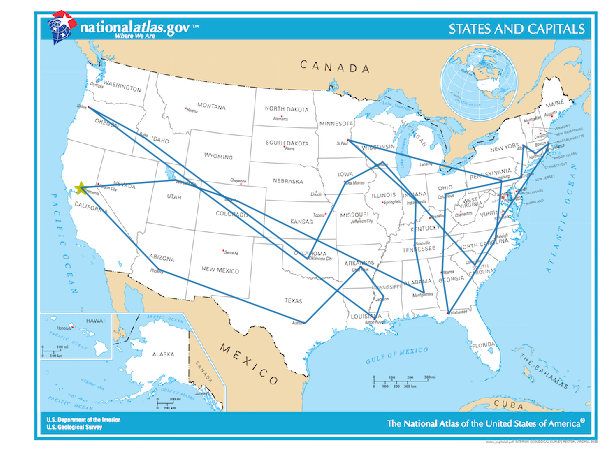

In [9]:
def RandomRestartRunner(cities, algorithm, kwargs, swap_size=29, iterations=None, timeout=None):
    global_start_time = time.perf_counter()
    best_costs  = []
    best_swaps  = []
    best_result = None
    best_path_cost = np.inf
    
    is_timeout = False
    if not iterations: iterations = 100 if not timeout else sys.maxsize
        
    for n in range(1,int(iterations)+1):
        best_cost = np.inf
        best_swap = 0

        # cities        = random.sample(cities, len(cities))
        capitals_tsp  = TravelingSalesmanProblem(cities, shuffle=True, swap_size=swap_size)
        starting_city = capitals_tsp.path[0]        
        solver        = algorithm(**kwargs)
        start_time    = time.perf_counter()
        result        = solver.solve(capitals_tsp)
        stop_time     = time.perf_counter()
        if -result.utility < best_cost: 
            best_cost = -result.utility
            best_swap = swap_size
            if best_cost < best_path_cost:
                best_path_cost = best_cost
                best_result    = result
        best_costs.append(best_cost)
        best_swaps.append(best_swap)   
        
        if time.perf_counter() - global_start_time > timeout: is_timeout = True
        if np.log10(n) % 1 == 0 or np.log10(n/5) % 1 == 0 or n == iterations or is_timeout:
            print(
                "{:10s} | {:5d} tries | min: {:.0f} | avg: {:.0f} | max: {:.0f} | std: {:3.0f} | time: {:6.3f}s"
                .format(algorithm.__name__, n, min(best_costs), np.mean(best_costs), max(best_costs), np.std(best_costs), (time.perf_counter() - global_start_time))
            )
        if is_timeout: break
    return best_result
            
    
result = RandomRestartRunner(cities, HillClimbingSolver, {"epochs": 100}, timeout=60)
show_path(result.coords, cities[0])

## III. Local Beam Search
Next, complete the `solve()` method for the `LocalBeamSolver` class below.

Local beam search is identical to the hill climbing algorithm except that it begins with k randomly generated states and at each step it selects the k best successors from the complete list of neighbors over all k states, then repeats.

In [10]:
class LocalBeamSolver:
    """
    Parameters
    ----------
    beam_width : int
        The number of samples to maintain during search.
    
    epochs : int
        The upper limit on the number of rounds to perform hill climbing; the
        algorithm terminates and returns the best observed result when this
        iteration limit is exceeded.
    """
    
    def __init__(self, beam_width=5, max_epochs=100, early_stopping=True, include_self=True):
        self.beam_width     = beam_width
        self.max_epochs     = max_epochs
        self.epochs_used    = 0
        self.early_stopping = early_stopping
        self.include_self   = include_self

    def solve(self, problem):
        """ Optimize the input problem by applying local beam search.

        Parameters
        ----------
        problem : Problem
            An initialized instance of an optimization problem. The Problem class
            interface must implement a callable method "successors()" which returns
            a iterable sequence (i.e., a list or generator) of the states in the
            neighborhood of the current state, and a property "utility" which returns
            a fitness score for the state. (See the `TravelingSalesmanProblem` class
            for more details.)

        Returns
        -------
        Problem
            The resulting approximate solution state of the optimization problem

        See Also
        --------
        local_beam_search() pseudocode
            https://
        """
        # DONE: Implement this function!        
        self.epochs_used = 0
        best_score = -np.inf
        beam = ( problem, )
        for epoch in range(1, self.max_epochs+1):
            successors = chain(*[
                successor.successors() 
                for successor in beam
            ])
            if self.include_self: 
                successors = chain(beam, successors)
                
            beam = sorted(successors, key=lambda s: s.utility, reverse=True)[:self.beam_width]            
            if best_score < beam[0].utility:  # hill climbing
                best_score = beam[0].utility
            else: 
                if self.early_stopping:
                    break
        self.epochs_used = epoch
        return beam[0]

### Run the Local Beam Search Solver

Notes:
- time taken increases linearly with beam_size
- larger beam sizes produce better results, but with plateau's of performance (1,2,8,256)
  - beam search can get stuck in local optima, sometimes increasing beam size will worsen performance
- epochs_used tends to be in the range 10-16: 
- include_self (usually) produces same or (slightly) better results than not (except occasionally for large beams)
- without include_self: time_taken is linear to number of epochs
- sorting is expensive: (include_self + not early_stopping) has similar performance to (include_self + early_stopping)
  - once convergance is reached, everything is cached and the beam is already sorted
- (not include_self + not early_stopping) will usually produce same results as (include_self + early_stopping) but much slower

swap:   3 | beam_width:    1 | self: True  | early: True  | path: 7784 -> 6199 | time:     26ms | epochs_used:  12
swap:   3 | beam_width:    1 | self: True  | early: False | path: 7784 -> 6199 | time:     27ms | epochs_used:  50
swap:   3 | beam_width:    1 | self: False | early: True  | path: 7784 -> 6200 | time:     25ms | epochs_used:  12
swap:   3 | beam_width:    1 | self: False | early: False | path: 7784 -> 6200 | time:     87ms | epochs_used:  50

swap:   3 | beam_width:    2 | self: True  | early: True  | path: 7784 -> 6199 | time:     44ms | epochs_used:  12
swap:   3 | beam_width:    2 | self: True  | early: False | path: 7784 -> 6199 | time:     50ms | epochs_used:  50
swap:   3 | beam_width:    2 | self: False | early: True  | path: 7784 -> 6200 | time:     44ms | epochs_used:  12
swap:   3 | beam_width:    2 | self: False | early: False | path: 7784 -> 6200 | time:    179ms | epochs_used:  50

swap:   3 | beam_width:    4 | self: True  | early: True  | path: 7784 -> 6199

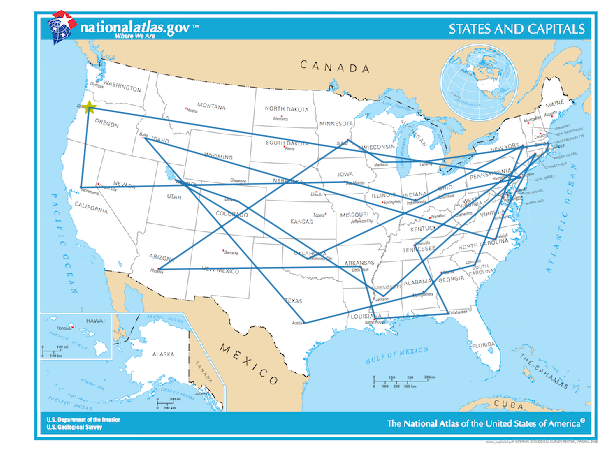

In [11]:
import gc
import time
# random.shuffle(capitals_list)

best_cost = np.inf
best_path = ()

def LocalBeamRunner(cities, beam_width=256, include_self=True, early_stopping=True, swap_size=29):
    global best_cost
    global best_path    
    
    gc.collect(); time.sleep(0.1);
    capitals_tsp  = TravelingSalesmanProblem(cities, shuffle=False, swap_size=swap_size)
    starting_city = capitals_tsp.path[0]        

    solver = LocalBeamSolver(
        beam_width     = beam_width, 
        max_epochs     = 50, 
        early_stopping = early_stopping,
        include_self   = include_self,                
    )
    start_time = time.perf_counter()
    result     = solver.solve(capitals_tsp)
    cost       = -result.utility
    stop_time  = time.perf_counter()
    if cost < best_cost:
        best_cost = cost
        best_path = result.coords
    print("swap: {:3d} | beam_width: {:4d} | self: {:5s} | early: {:5s} | path: {:.0f} -> {:.0f} | time: {:6.0f}ms | epochs_used: {:3d}"
          .format(swap_size, beam_width, str(include_self), str(early_stopping), -capitals_tsp.utility, -result.utility, ((stop_time - start_time) * 1000), solver.epochs_used)
    )
    return result


for beam_width in range(0,10):
    beam_width = 2**beam_width    
    for include_self in [True, False]:        
        for early_stopping in [True, False]:  
            LocalBeamRunner(cities, beam_width, include_self, early_stopping, swap_size=3)            
    print()
print()
print(best_path)
show_path(best_path, starting_city)

swap:  29 | beam_width:    1 | self: True  | early: True  | path: 7784 -> 6042 | time:     47ms | epochs_used:   8
swap:  29 | beam_width:    1 | self: True  | early: False | path: 7784 -> 6042 | time:     49ms | epochs_used:  50
swap:  29 | beam_width:    1 | self: False | early: True  | path: 7784 -> 6045 | time:     41ms | epochs_used:   8
swap:  29 | beam_width:    1 | self: False | early: False | path: 7784 -> 6045 | time:    130ms | epochs_used:  50

swap:  29 | beam_width:    2 | self: True  | early: True  | path: 7784 -> 6042 | time:     52ms | epochs_used:   8
swap:  29 | beam_width:    2 | self: True  | early: False | path: 7784 -> 6042 | time:     55ms | epochs_used:  50
swap:  29 | beam_width:    2 | self: False | early: True  | path: 7784 -> 6045 | time:     51ms | epochs_used:   8
swap:  29 | beam_width:    2 | self: False | early: False | path: 7784 -> 6045 | time:    195ms | epochs_used:  50

swap:  29 | beam_width:    4 | self: True  | early: True  | path: 7784 -> 6042

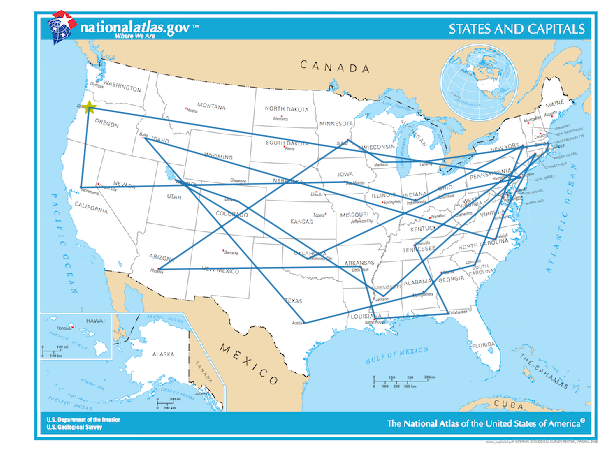

In [12]:
for beam_width in range(0,4):
    beam_width = 2**beam_width    
    for include_self in [True, False]:        
        for early_stopping in [True, False]:  
            LocalBeamRunner(cities, beam_width, include_self, early_stopping, swap_size=29)            
    print()
print()
print(best_path)
show_path(best_path, starting_city)

## IV. Simulated Annealing
Complete the `schedule()` and `solve()` methods of the `SimulatedAnnealingSolver` class below.  Simulated annealing repeatedly generates successors in the neighborhood of the current state and considers moving there according to an acceptance probability distribution parameterized by a cooling schedule.

> The simulated annealing algorithm, a version of stochastic hill climbing where some downhill moves are allowed. Downhill moves are accepted readily early in the annealing schedule and then less often as time goes on. The schedule input determines the value of the temperature T as a function of time. [AIMA 3rd ed, Chapter 4]

![](pseudocode/simulated_annealing.png)
Pseudocode for the [simulated-annealing function](https://github.com/aimacode/aima-pseudocode/blob/master/md/Simulated-Annealing.md) from the AIMA textbook.  Note that our Problem class is already a "node", so the MAKE-NODE line is not required.

In [13]:
class SimulatedAnnealingSolver:
    """
    Parameters
    ----------
    alpha : numeric
        The decay rate parameter controlling the exponential temperature distribution.
    
    initial_temperature : numeric
        The initial temperature for the temperature distribution.
    """
    
    def __init__(self, alpha=0.95, initial_temperature=1e6):
        self.alpha = alpha
        self.initial_temperature = initial_temperature
        self.epochs_used = 0
        self.__cutoff_temperature = 1e-8  # arbitrary small constant
    
    def schedule(self, time):
        """ Return the temperature at the specified time according to the temperature schedule
        
        The most commonly used temperature schedule is an exponential:
            
            T = T_i * alpha^t
            
        Where T_i is the intial temperature, alpha is a decay rate constant, and t is the
        current time step number.
        """
        # DONE: implement this function
        return self.initial_temperature * self.alpha ** time
    
    def solve(self, problem: TravelingSalesmanProblem) -> TravelingSalesmanProblem:
        """ Optimize the input problem by applying simulated annealing.

        Parameters
        ----------
        problem : Problem
            An initialized instance of an optimization problem. The Problem class
            interface must implement a callable method "get_successors()" which
            returns a random neighbor of the current states, and a property "utility"
            which returns a fitness score for the state. (See the
            `TravelingSalesmanProblem` class for more details.)

        Returns
        -------
        Problem
            The resulting approximate solution state of the optimization problem

        Notes
        -----
            (1) DO NOT include the MAKE-NODE line from the AIMA pseudocode

            (2) Modify the termination condition in the pseudocode so that the function
                returns when the temperature falls below `self.__cutoff_temperature`
        """
        # TODO: Implement this function
        current = problem
        time    = 0        
        temp    = self.schedule(time)        
        self.epochs_used = 0        
        while temp >= self.__cutoff_temperature:
            time += 1
            self.epochs_used += 1
            temp  = self.schedule(time)
            successor = problem.get_successor()
            if successor.utility > current.utility:  # exp(0/temp) == 1.0
                current = successor
            else:
                delta = abs(current.utility - successor.utility)
                if random.random() <= math.exp(-delta/temp):
                    current = successor            
        return current

### Run the Simulated Annealing Solver

- runtime 
  - is proportial to number of epochs
  - most strongly affected by alpha, but log(log()) affected by initial_temperature
  - once convergance is reached, extra epochs have no extra effect of path score
  
- alpha
    - setting alpha too high (>0.999) results in a very long runtime
    - setting alpha too high (<0.95)  results in worse or inconsistant results
    - 0.99 is about right
    
- initial_temperature:
  - setting too low will result in an insufficent number of epochs
  - setting too high will run an unnessasary number of epochs
  - even a fairly low initial temp, such as 1 will give good results (with a sufficently high alpha)
 
- summary:
  - settings mostly don't matter, as long as they are not too extreme
  - temp = 1 + alpha = 0.99 will produce 
  
NOTE: due to randomness, Simulated Annealing will occasionally produce random results

swap:  29 | temp: 1e+08 | alpha: 0.9999 | path: 7784 -> 6803 | time:   2938ms | epochs: 368396
swap:  29 | temp: 1e+08 | alpha: 0.9990 | path: 7784 -> 6803 | time:    339ms | epochs: 36823
swap:  29 | temp: 1e+08 | alpha: 0.9950 | path: 7784 -> 6803 | time:     82ms | epochs:  7350
swap:  29 | temp: 1e+08 | alpha: 0.9900 | path: 7784 -> 6803 | time:     54ms | epochs:  3666
swap:  29 | temp: 1e+08 | alpha: 0.9800 | path: 7784 -> 6803 | time:     50ms | epochs:  1824
swap:  29 | temp: 1e+08 | alpha: 0.9500 | path: 7784 -> 6803 | time:     27ms | epochs:   719
swap:  29 | temp: 1e+08 | alpha: 0.9000 | path: 7784 -> 6803 | time:     18ms | epochs:   350
swap:  29 | temp: 1e+08 | alpha: 0.8000 | path: 7784 -> 7139 | time:     13ms | epochs:   166
swap:  29 | temp: 1e+08 | alpha: 0.7000 | path: 7784 -> 7139 | time:      9ms | epochs:   104

swap:  29 | temp: 1e-08 | alpha: 0.9990 | path: 7784 -> 7740 | time:      2ms | epochs:     1
swap:  29 | temp: 1e-06 | alpha: 0.9990 | path: 7784 -> 68

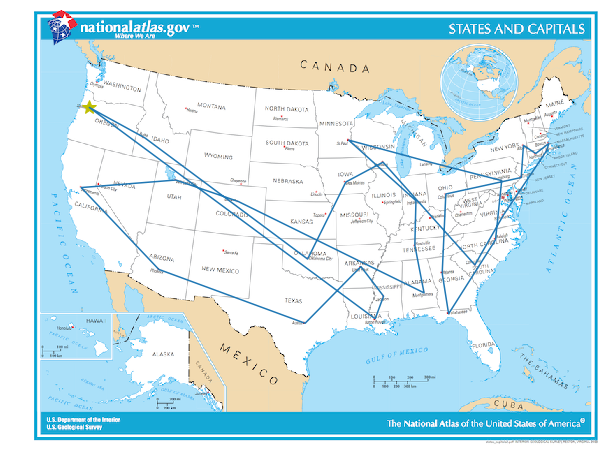

In [14]:
# random.shuffle(capitals_list)

def SimulatedAnnealingRunner(cities, initial_temperature=1e8, alpha=0.99, swap_size=29):
    capitals_tsp  = TravelingSalesmanProblem(capitals_list[:num_cities], shuffle=False, swap_size=swap_size)
    starting_city = capitals_tsp.path[0]        

    solver     = SimulatedAnnealingSolver(alpha=alpha, initial_temperature=initial_temperature)
    start_time = time.perf_counter()
    result     = solver.solve(capitals_tsp)
    stop_time  = time.perf_counter()
    print("swap: {:3d} | temp: {:3.0e} | alpha: {:.4f} | path: {:.0f} -> {:.0f} | time: {:6.0f}ms | epochs: {:5d}"
        .format(swap_size, initial_temperature, alpha, -capitals_tsp.utility, -result.utility, ((stop_time - start_time) * 1000), solver.epochs_used)
    )
    return result


initial_temperature = 1e8
for alpha in [0.9999, 0.999, 0.995, 0.99, 0.98, 0.95, 0.9, 0.8, 0.7]:
    SimulatedAnnealingRunner(cities, initial_temperature=initial_temperature, alpha=alpha)
print()


for alpha in [0.999, 0.99, 0.90]:
    for initial_temperature in range(-8,20,2):
        initial_temperature = 10**initial_temperature
        SimulatedAnnealingRunner(cities, initial_temperature=initial_temperature, alpha=alpha)
    print()

print(result.path)
show_path(result.coords, starting_city)

## V. Late Acceptance Hill Climbing
The late acceptance hill-climbing search algorithm combines properties of both basic hill climbing and simulated annealing by accepting some downhill moves when the neighbor's value is higher than one of the previous best values in an array.

![](pseudocode/lahc.png)

You can read about LAHC (including pseudocode) in "The Late Acceptance Hill-Climbing Heuristic" by Burke & Bykov [here](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.261.3472&rep=rep1&type=pdf). (A copy of the PDF is also included in the git repo for this project.)

In [15]:
class LAHCSolver:
    """
    Parameters
    ----------
    Lfa : numeric
        The size of the late acceptance value array.

    epochs : numeric
        The upper limit on the number of rounds to perform hill climbing; the
        algorithm terminates and returns the best observed result when this
        iteration limit is exceeded.
    """
    
    def __init__(self, Lfa=5, epochs=100):
        self.epochs = epochs
        self.Lfa = Lfa
        self.epochs_used = 0
    
    def solve(self, problem: TravelingSalesmanProblem) -> TravelingSalesmanProblem:
        """ Optimize the input problem by applying late-acceptance hill climbing.

        Parameters
        ----------
        problem : Problem
            An initialized instance of an optimization problem. The Problem class
            interface must implement a callable method "successors()" which returns
            a iterable sequence (i.e., a list or generator) of the states in the
            neighborhood of the current state, and a property "utility" which returns
            a fitness score for the state. (See the `TravelingSalesmanProblem` class
            for more details.)

        Returns
        -------
        Problem
            The resulting approximate solution state of the optimization problem

        See Also
        --------
        late_acceptance() pseudocode
            https://
        """
        # DONE: Implement this function!
        current = problem
        history = [ problem.utility for n in range(self.Lfa) ]        
        self.epochs_used = 0
        for epoch in range(self.epochs):
            self.epochs_used += 1
            successor = problem.get_successor()
            v = epoch % self.Lfa
            # if successor.utility >= min(current.utility, history[v]):  # Hill Climbing
            if successor.utility >= current.utility or successor.utility >= history[v]:  # Hill Climbing                
                current = successor
            history[v] = current.utility
            
        self.epochs_used = epoch
        return current

### Run the Late Acceptance Hill Climbing Solver

swap:  28 | Lfa:       1 | epochs:      1 | path: 7784 -> 7669 | time:      4ms
swap:  28 | Lfa:       2 | epochs:      1 | path: 7784 -> 7665 | time:      3ms
swap:  28 | Lfa:       4 | epochs:      1 | path: 7784 -> 7784 | time:      3ms
swap:  28 | Lfa:       8 | epochs:      1 | path: 7784 -> 7606 | time:      3ms
swap:  28 | Lfa:      16 | epochs:      1 | path: 7784 -> 7784 | time:      4ms
swap:  28 | Lfa:      32 | epochs:      1 | path: 7784 -> 7784 | time:      3ms
swap:  28 | Lfa:      64 | epochs:      1 | path: 7784 -> 7784 | time:      4ms
swap:  28 | Lfa:     128 | epochs:      1 | path: 7784 -> 7784 | time:      4ms
swap:  28 | Lfa:     256 | epochs:      1 | path: 7784 -> 7784 | time:      3ms
swap:  28 | Lfa:     512 | epochs:      1 | path: 7784 -> 7784 | time:      3ms
swap:  28 | Lfa:    1024 | epochs:      1 | path: 7784 -> 7784 | time:      3ms
swap:  28 | Lfa:    2048 | epochs:      1 | path: 7784 -> 7784 | time:      6ms

swap:  28 | Lfa:       1 | epochs:     

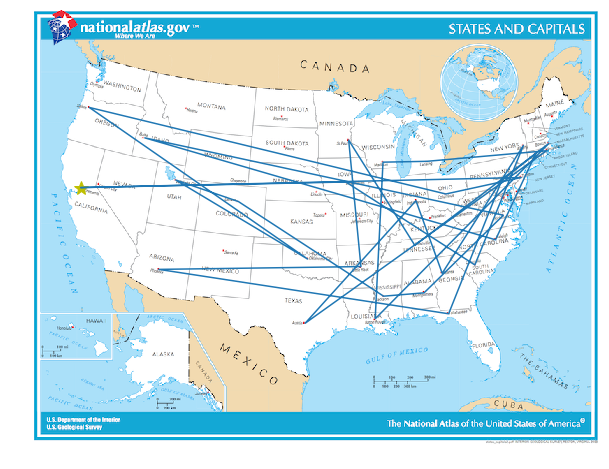

In [16]:
def LAHCRunner(cities, Lfa=64, epochs=10000, swap_size=29):
    capitals_tsp  = TravelingSalesmanProblem(capitals_list[:num_cities], shuffle=False, swap_size=swap_size)
    starting_city = capitals_tsp.path[0]        

    solver     = LAHCSolver(Lfa=Lfa, epochs=epochs)
    start_time = time.perf_counter()
    result     = solver.solve(capitals_tsp)
    stop_time  = time.perf_counter()
    print("swap: {:3d} | Lfa: {:7d} | epochs: {:6d} | path: {:.0f} -> {:.0f} | time: {:6.0f}ms"
        .format(capitals_tsp.swap_size, Lfa, epochs, -capitals_tsp.utility, -result.utility, ((stop_time - start_time) * 1000))
    )
    return result

for epochs in range(0,5):    
    for Lfa in range(0,12,1):
        result = LAHCRunner(cities, 2**Lfa, 5**epochs, swap_size=29)
    print()

show_path(result.coords, cities[0])

## Comparison

Best one-shot results

swap:  28 | epochs:  20 | path: 7784 -> 6042 | time:     55ms | epochs:     8


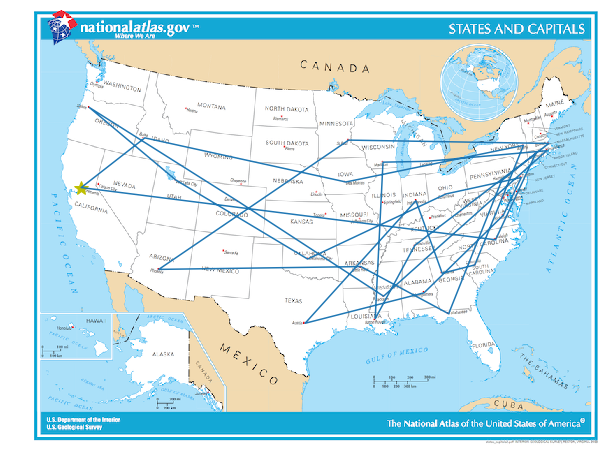

In [17]:
result = HillClimbingRunner(cities);
show_path(result.coords, cities[0])

swap:  29 | beam_width:   32 | self: True  | early: True  | path: 7784 -> 5980 | time:    586ms | epochs_used:  10


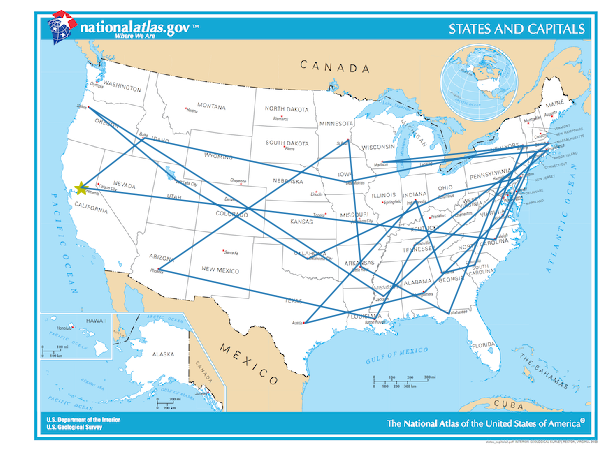

In [18]:
result = LocalBeamRunner(cities, beam_width=32, include_self=True, early_stopping=True); 
show_path(result.coords, cities[0])

swap:  29 | temp: 1e+00 | alpha: 0.9900 | path: 7784 -> 6803 | time:     64ms | epochs:  1833


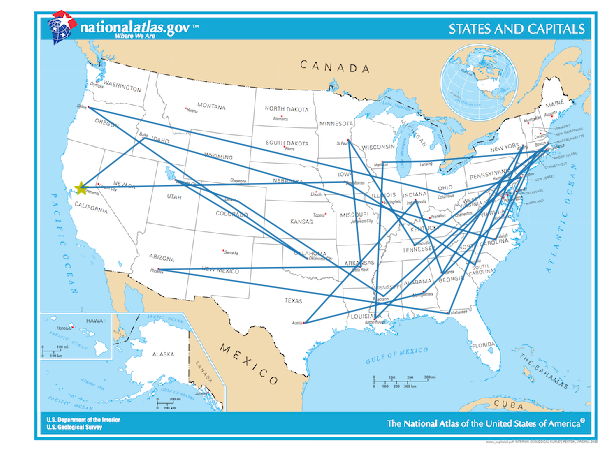

In [19]:
result = SimulatedAnnealingRunner(cities, alpha=0.99, initial_temperature=1)
show_path(result.coords, cities[0])

swap:  28 | Lfa:       2 | epochs:      5 | path: 7784 -> 7696 | time:      6ms


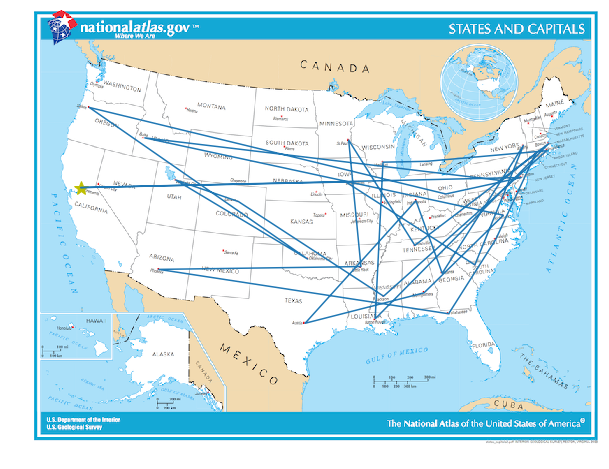

In [20]:
result = LAHCRunner(cities, Lfa=2, epochs=5)
show_path(result.coords, cities[0])

Best random restart results in under a minute

HillClimbingSolver |     1 tries | min: 5260 | avg: 5260 | max: 5260 | std:   0 | time:  0.084s
HillClimbingSolver |     5 tries | min: 4997 | avg: 5412 | max: 5958 | std: 315 | time:  0.276s
HillClimbingSolver |    10 tries | min: 4997 | avg: 5599 | max: 6796 | std: 488 | time:  0.540s
HillClimbingSolver |    50 tries | min: 4428 | avg: 5498 | max: 6796 | std: 536 | time:  2.549s
HillClimbingSolver |   100 tries | min: 4359 | avg: 5444 | max: 6832 | std: 557 | time:  5.095s
HillClimbingSolver |   500 tries | min: 3936 | avg: 5387 | max: 6873 | std: 554 | time: 24.976s
HillClimbingSolver |  1000 tries | min: 3936 | avg: 5398 | max: 6974 | std: 547 | time: 50.833s
HillClimbingSolver |  1191 tries | min: 3810 | avg: 5400 | max: 6974 | std: 556 | time: 60.026s


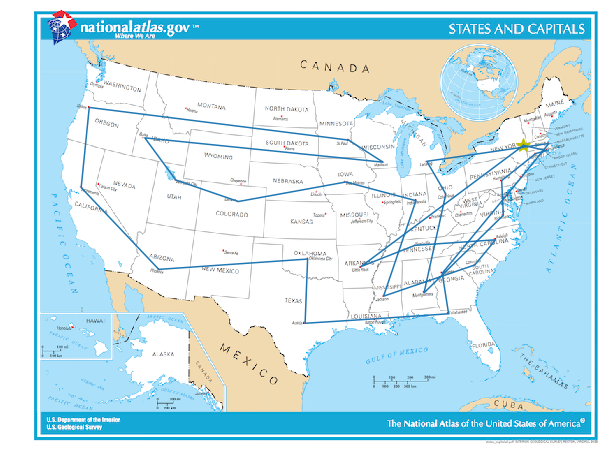

In [21]:
result = RandomRestartRunner(cities, HillClimbingSolver, {"epochs": 100}, timeout=60)
show_path(result.coords, result.path[0])

{'max_epochs': 100, 'beam_width': 2}
LocalBeamSolver |     1 tries | min: 5579 | avg: 5579 | max: 5579 | std:   0 | time:  0.109s
LocalBeamSolver |     5 tries | min: 5248 | avg: 5638 | max: 6013 | std: 255 | time:  0.442s
LocalBeamSolver |    10 tries | min: 5248 | avg: 5575 | max: 6013 | std: 208 | time:  0.830s
LocalBeamSolver |    50 tries | min: 4026 | avg: 5428 | max: 6374 | std: 535 | time:  3.711s
LocalBeamSolver |   100 tries | min: 4026 | avg: 5395 | max: 6404 | std: 513 | time:  7.244s
LocalBeamSolver |   500 tries | min: 3864 | avg: 5335 | max: 6999 | std: 547 | time: 35.504s
LocalBeamSolver |   842 tries | min: 3619 | avg: 5328 | max: 7179 | std: 534 | time: 60.009s

{'max_epochs': 100, 'beam_width': 4}
LocalBeamSolver |     1 tries | min: 5484 | avg: 5484 | max: 5484 | std:   0 | time:  0.155s
LocalBeamSolver |     5 tries | min: 4728 | avg: 5232 | max: 5894 | std: 417 | time:  0.618s
LocalBeamSolver |    10 tries | min: 4564 | avg: 5280 | max: 6020 | std: 541 | time:  1.

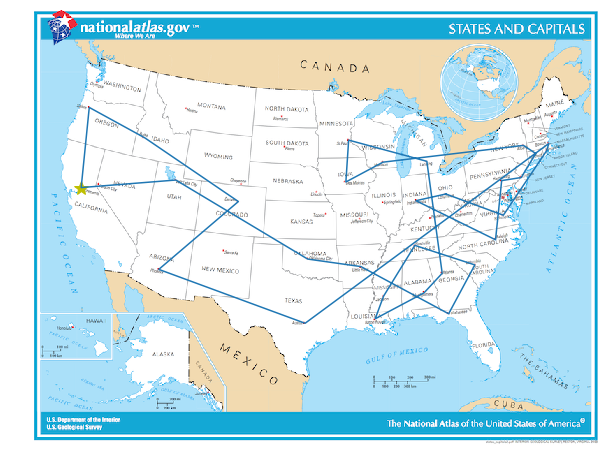

In [22]:
results = []
for beam_width in range(1,6):
    beam_width = 2**beam_width    
    kwargs = {"beam_width":beam_width,"max_epochs":100}
    print(kwargs)
    result = RandomRestartRunner(cities, LocalBeamSolver, kwargs, timeout=60)        
    results.append(result)
    print()
result = sorted(results, reverse=True, key=lambda r: r.utility )[0]
show_path(result.coords, cities[0])

{'alpha': 0.99}
SimulatedAnnealingSolver |     1 tries | min: 6344 | avg: 6344 | max: 6344 | std:   0 | time:  0.073s
SimulatedAnnealingSolver |     5 tries | min: 6344 | avg: 7214 | max: 8307 | std: 685 | time:  0.308s
SimulatedAnnealingSolver |    10 tries | min: 5887 | avg: 6847 | max: 8307 | std: 679 | time:  0.555s
SimulatedAnnealingSolver |    50 tries | min: 5418 | avg: 6816 | max: 8307 | std: 630 | time:  2.571s
SimulatedAnnealingSolver |   100 tries | min: 5418 | avg: 6883 | max: 8307 | std: 567 | time:  5.033s
SimulatedAnnealingSolver |   500 tries | min: 5065 | avg: 6981 | max: 8746 | std: 624 | time: 24.647s
SimulatedAnnealingSolver |  1000 tries | min: 5065 | avg: 6952 | max: 8746 | std: 603 | time: 49.322s
SimulatedAnnealingSolver |  1212 tries | min: 5065 | avg: 6944 | max: 8746 | std: 600 | time: 60.027s

{'alpha': 0.9}
SimulatedAnnealingSolver |     1 tries | min: 6159 | avg: 6159 | max: 6159 | std:   0 | time:  0.019s
SimulatedAnnealingSolver |     5 tries | min: 6159

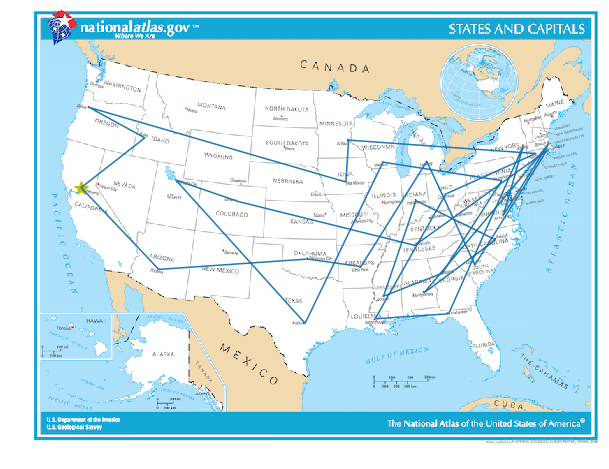

In [23]:
results = []
for alpha in [0.99, 0.9]:
    print({"alpha": alpha })
    result = RandomRestartRunner(cities, SimulatedAnnealingSolver, {"alpha":alpha}, timeout=60)
    results.append(result)
    print()
           
result = sorted(results, reverse=True, key=lambda r: r.utility )[0]
show_path(result.coords, cities[0])

{'Lfa': 2, 'epochs': 20}
LAHCSolver |     1 tries | min: 7683 | avg: 7683 | max: 7683 | std:   0 | time:  0.007s
LAHCSolver |     5 tries | min: 6930 | avg: 7459 | max: 7868 | std: 318 | time:  0.032s
LAHCSolver |    10 tries | min: 6119 | avg: 7257 | max: 7868 | std: 491 | time:  0.060s
LAHCSolver |    50 tries | min: 5751 | avg: 7363 | max: 8302 | std: 564 | time:  0.276s
LAHCSolver |   100 tries | min: 5751 | avg: 7412 | max: 9132 | std: 567 | time:  0.461s
LAHCSolver |   500 tries | min: 5674 | avg: 7378 | max: 9132 | std: 594 | time:  1.957s
LAHCSolver |  1000 tries | min: 5590 | avg: 7353 | max: 9164 | std: 608 | time:  3.815s
LAHCSolver |  2661 tries | min: 5342 | avg: 7372 | max: 9290 | std: 615 | time: 10.003s

{'Lfa': 4, 'epochs': 40}
LAHCSolver |     1 tries | min: 7254 | avg: 7254 | max: 7254 | std:   0 | time:  0.008s
LAHCSolver |     5 tries | min: 7254 | avg: 7571 | max: 7883 | std: 217 | time:  0.036s
LAHCSolver |    10 tries | min: 6251 | avg: 7302 | max: 7883 | std: 4

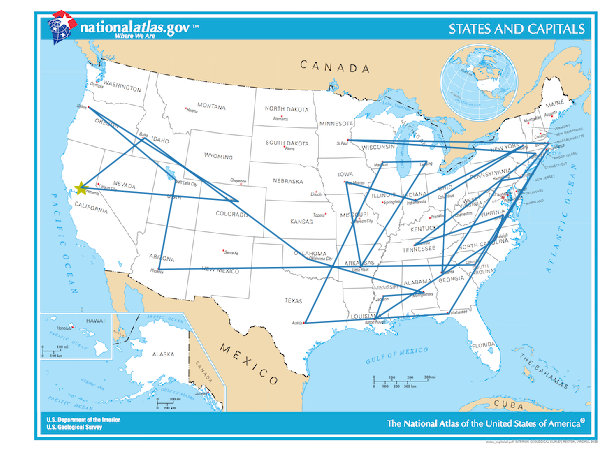

In [24]:
results = []
for Lfa in [2,4,8,16]:
    for epochs in { 20,10*Lfa }:
        kwargs = {"epochs": epochs, "Lfa": Lfa }
        print(kwargs)
        result = RandomRestartRunner(cities, LAHCSolver, kwargs, timeout=10)
        results.append(result)
        print()
           
result = sorted(results, reverse=True, key=lambda r: r.utility )[0]
show_path(result.coords, cities[0])

## VI. Additional Experiments (Optional)
Here are some ideas for additional experiments with various settings and parameters once you've completed the lab.

  - Experiment with the parameters for each solver.  How do they affect the results?
  - Use a different schedule function for the simulated annealing solver (something other than exponential decay).  Is the algorithm still effective?
  - Use a different distance metric for get_value (e.g., we used the L2-norm (Euclidean distance), try the L1-norm (manhattan distance) or L$\infty$-norm (uniform norm)
  - Implement a genetic algorithm solver (ref: [here](https://iccl.inf.tu-dresden.de/w/images/b/b7/GA_for_TSP.pdf)) and compare with the other local search algorithms

Share and discuss your results with your peers!

In [74]:
class AntColonySolver:
    """
    Parameters
    ----------
    ant_count : numeric
        Number of ants

    ant_speed : numeric
        How fast do ants move

    ant_slowdown : numeric
        Slow 


    epochs : numeric
        The upper limit on the number of rounds to perform hill climbing; the
        algorithm terminates and returns the best observed result when this
        iteration limit is exceeded.
    """
    
    def __init__(self, ant_count=0, ant_speed=0, ant_slowdown=False, ant_smell=1, timeout=60, verbose=False):
        self.epochs       = epochs
        self.ant_count    = ant_count
        self.ant_speed    = ant_speed
        self.ant_slowdown = ant_slowdown
        self.ant_smell    = ant_smell
        self.timeout      = timeout
        self.verbose      = verbose
        
    
    def new_ant(self, problem):
        return { 
            "distance":  0, 
            "path":      [ problem.path[0] ], 
            "remaining": set(problem.path[1:]), 
            "path_cost": 0,
            "steps":     0
        }
    
    
    def next_node(self, ant, pheromones, distances):
        this_node   = ant['path'][-1]
        
        weights     = []
        weights_sum = 0  
        if not ant['remaining']: return ant['path'][0]  # return home
        for next_node in ant['remaining']:
            if next_node == this_node: continue

            # Prefer shorter paths                
            reward = pheromones[this_node][next_node]
            weights.append( (reward, next_node) )
            weights_sum   += reward
        
        rand = random.random()
        for (weight, next_node) in weights:
            weight_norm = weight / weights_sum
            if rand > weight_norm: rand -= weight_norm
            else:                  break
        return next_node
     
#     def reward_pheromones(ant, pheromones):
        
                
    def solve(self, problem: TravelingSalesmanProblem) -> TravelingSalesmanProblem:
        """ Optimize the input problem by applying late-acceptance hill climbing.

        Parameters
        ----------
        problem : Problem
            An initialized instance of an optimization problem. The Problem class
            interface must implement a callable method "successors()" which returns
            a iterable sequence (i.e., a list or generator) of the states in the
            neighborhood of the current state, and a property "utility" which returns
            a fitness score for the state. (See the `TravelingSalesmanProblem` class
            for more details.)

        Returns
        -------
        Problem
            The resulting approximate solution state of the optimization problem

        See Also
        --------
        late_acceptance() pseudocode
            https://
        """      
        distances = {
            source: {
                dest: dist(source[1], dest[1])
                for dest in problem.path
            }
            for source in problem.path
        }
        pheromones = {
            source: {
                dest: 1
                for dest in problem.path
            }
            for source in problem.path
        }                

    
        if not self.ant_count:
            self.ant_count = len(problem.path)
        if not self.ant_speed:
            self.ant_speed = np.median(list(chain(*[ d.values() for d in distances.values() ]))) / 5
        ant_speed = self.ant_speed  
        ants = [ self.new_ant(problem) for n in range(self.ant_count) ]

        self.ants_used = 0
        best_path      = None
        best_path_cost = np.inf        
        best_epochs    = []                
        epoch          = 0
        time_start     = time.perf_counter()
        while True:
            epoch += 1            
            for i, ant in enumerate(ants):
                if ant['distance'] > 0:
                    ant['distance'] -= ant_speed
                    ant['steps']    += 1
                else:  
                    # ant arrived at next_node
                    this_node = ant['path'][-1]
                    next_node = self.next_node(ant, pheromones, distances)
                    ant['distance']    = distances[ this_node ][ next_node ]
                    ant['remaining']  -= {this_node}
                    ant['path'].append( next_node )                    
                    ant['path_cost']  += ant['distance']
                    
                    reward = self.ant_smell / (1 + distances[this_node][next_node])  # avoid divide by zero
                    pheromones[this_node][next_node] += reward
                    pheromones[next_node][this_node] += reward
                    
                    # ant returned home
                    if not ant['remaining'] and ant['path'][0] == ant['path'][-1]: 
                        if ant['path_cost'] < best_path_cost:
                            best_path_cost = ant['path_cost']
                            best_path      = ant['path'] 
                            best_epochs   += [ epoch ]
                            if self.verbose:
                                print({ "epoch": epoch, "path_cost": int(ant['path_cost']), "steps": ant['steps'] })
                        ants[i] = self.new_ant(problem)  # reset ant                    
                        self.ants_used += 1

            # Do we terminate
            if not len(best_epochs) >= 1: 
                continue  # always wait for at least 1 solution

            if self.timeout:
                clock = time.perf_counter() - time_start
                if clock > self.timeout: break
                if self.ant_slowdown: 
                    ant_speed = int(self.ant_speed * (1-clock/self.timeout) + 1)
            else:
                # We have reached convergence                
                if self.ants_used > 10000 and len(best_epochs) >= 3 and best_epochs[-1] * 2 < epoch: 
                    break                
                
        self.epochs_used = epochs
        return TravelingSalesmanProblem(best_path)


ant_count:    1 | ant_speed:    0 | ant_slowdown: False | path: 7784 -> 2444 | time:   60s | ants_used:   52120
ant_count:   30 | ant_speed:    0 | ant_slowdown: False | path: 7784 -> 2241 | time:   60s | ants_used:   70277
ant_count:    1 | ant_speed:    1 | ant_slowdown: False | path: 7784 -> 3584 | time:   60s | ants_used:    4216
ant_count:   30 | ant_speed:    1 | ant_slowdown: False | path: 7784 -> 2951 | time:   60s | ants_used:   11373


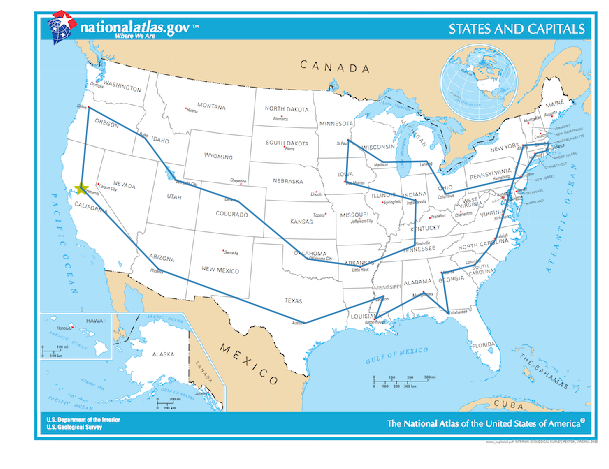

In [82]:
def AntColonyRunner(cities, ant_count=1000, ant_speed=1, ant_smell=1, ant_slowdown=False, timeout=60, verbose=False):
    capitals_tsp  = TravelingSalesmanProblem(cities, shuffle=False, swap_size=swap_size)
    starting_city = capitals_tsp.path[0]        

    solver     = AntColonySolver(ant_count=ant_count, ant_speed=ant_speed, ant_smell=ant_smell, timeout=timeout, verbose=verbose)
    start_time = time.perf_counter()
    result     = solver.solve(capitals_tsp)
    stop_time  = time.perf_counter()
    print("ant_count: {:4d} | ant_speed: {:4d} | ant_slowdown: {:5s} | path: {:.0f} -> {:.0f} | time: {:4.0f}s | ants_used: {:7d}"
        .format(ant_count, ant_speed, str(ant_slowdown), -capitals_tsp.utility, -result.utility, (stop_time - start_time), solver.ants_used)
    )
    return result

results = []
ant_speed = 0
for timeout in [60]:
    for ant_speed in [0,1]:
        for ant_count in [0,1]:
            kwargs = { 
                "ant_count": max(1, int(len(cities) * ant_count)), 
                "ant_speed": ant_speed, 
                "ant_slowdown": False, 
                "ant_smell": 1, 
                "timeout": timeout, 
                "verbose": False
            }    
            result = AntColonyRunner(cities, **kwargs)
            results.append( result )

result = sorted(results, reverse=True, key=lambda r: r.utility )[0]
show_path(result.coords, cities[0])

In [ ]:
result = AntColonyRunner(cities, ant_count=len(cities), ant_speed=10, ant_smell=3, epochs=100000)
show_path(result.coords, cities[0])